# Case Study for "Safe handling instructions for missing data"

This notebook uses Scott Cole's burrito dataset, presented during a lightning talk at [SciPy 2017](https://conference.scipy.org/scipy2017), licensed under MIT, available [here](https://github.com/srcole/burritos).

In [1]:
import os

from impyute.imputations.cs import em
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = (8, 5)
data_dir = 'data'
img_dir = 'img'
np.random.seed(0)

burrito = pd.read_excel(os.path.join(data_dir, 'burrito.xlsx'))

We're defining two helper functions here: one to recode the ingredients from `nan`/`'x'` into `0`/`1`, and another that we are going to use to scale the Likert scores for individual raters (which are known to vary wildly between raters, and are more reliable when normalized per rater).

In [2]:
def fix_binaries(value):
    if str(value).lower().strip() == 'x':
        return 1
    else:
        return 0
    
def scale(series):
    return (series - series.mean()) / series.std()

In [3]:
ranking_names = ['Cost', 'Meat', 'Uniformity', 'Salsa', 'Wrap', 'overall']
ingredient_names = ['Beef', 'Pico', 'Guac', 'Cheese', 'Sour cream', 'Pork', 'Chicken', 
               'Shrimp','Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Carrots', 
               'Cabbage', 'Sauce', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 
                'Nopales', 'Lobster', 'Queso', 'Egg', 'Mushroom', 
                'Avocado', 'Corn', 'Zucchini']

We're grabbing only the reviewers who have posted enough reviews that we can reliaby rescale them.

In [4]:
n_reviews = burrito.groupby('Reviewer')['Cost'].count()
n_reviews = n_reviews[n_reviews >= 10]
burrito = burrito.loc[burrito.Reviewer.isin(n_reviews.index)]
rankings = burrito.groupby('Reviewer')[ranking_names].transform(scale)

In [5]:
ingredients = burrito[ingredient_names].applymap(fix_binaries)
burrito = pd.concat([rankings, ingredients], axis=1).dropna()
print(burrito.shape)
burrito.head()

(231, 35)


,Cost,Meat,Uniformity,Salsa,Wrap,overall,Beef,Pico,Guac,Cheese,...,Pineapple,Ham,Nopales,Lobster,Queso,Egg,Mushroom,Avocado,Corn,Zucchini
0,-0.354733,-0.542106,0.687965,0.955789,0.108080,0.427646,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,-0.878739,-1.206906,0.687965,0.365796,0.926145,-0.725368,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,-1.493409,-1.524034,0.681981,-0.226181,0.801869,-0.815564,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.356262,-0.144338,1.085921,0.395285,0.874033,0.112648,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.304348,0.787495,1.585025,-0.814190,0.108080,1.004154,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


Here, we train a model on the dataset as-is.

In [6]:
x_train, x_test, t_train, t_test = train_test_split(
    burrito[burrito.columns.difference(['overall'])], burrito['overall'], test_size=0.2
)
reg = DecisionTreeRegressor()
reg.fit(x_train, t_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

The single most important predictor for the overall quality of a burrito is how tasty the meat is. The [uniformity of the burrito](https://medium.com/@luckyshirt/dear-guy-who-just-made-mt-burrito-fd08c0babb57) and salsa quality are the other notable features of good burritos.

In [7]:
row = "| {:<13.13} | {:<13.13} |"
print(row.format('feature', 'coefficient'))
important_features = np.where(reg.feature_importances_ > 0.1)[0]
for index in important_features:
    name = x_train.columns[index]
    value = reg.feature_importances_[index]
    print(row.format(name, value))
    reference_score = reg.score(x_test, t_test)

| feature       | coefficient   |
| Meat          | 0.5467465698323 |
| Salsa         | 0.1279211666636 |
| Uniformity    | 0.1598099891451 |


#### Impose MAR

We're going to pretend that our causal model is that people who really enjoy a burrito get distracted and forget to fill out some survey data. We randomly choose one variable to strike out for each of the best upper tritile of burrito. This reduces our effective data size rather dramatically.

In [8]:
missing = burrito.copy()
rows = missing[missing.overall > missing.overall.quantile(0.30)].index
cols = np.random.choice(['Cost', 'Meat', 'Salsa', 'Uniformity'], rows.size)
for row, col in zip(rows, cols):
    missing.loc[row, col] = np.nan
print(missing.dropna().shape)

(72, 35)


#### Diagnostics

It looks like there is a very strong relationship between which values are missing and the overall score, so we can't use listwise deletion and get unbiased results.

In [9]:
missing['has_nulls'] = pd.isnull(missing).sum(axis=1)

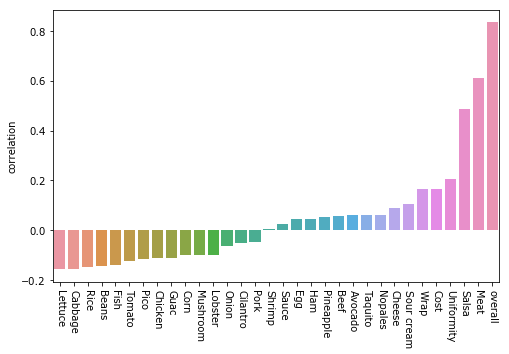

In [10]:
correlations = missing.corr().sort_values('has_nulls')[['has_nulls']]
ax = sns.barplot(x='index', y='has_nulls', 
                 data=correlations.dropna().drop('has_nulls', axis=0).reset_index())
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90)
ax.set_xlabel('')
ax.set_ylabel('correlation')
ax.figure.savefig(os.path.join(img_dir, 'corr_with_null.png'))
missing.drop('has_nulls', axis=1, inplace=True)


#### Expectation Maximization

Expectation maximization seems to do a pretty good job of recovering the importance of meat quality.

In [11]:
models = []
em_scores = []
for trial in range(5):
    corrected = pd.DataFrame(em(missing.values), index=missing.index, columns=missing.columns)
    x_train, x_test, t_train, t_test = train_test_split(
        corrected[corrected.columns.difference(['overall'])], corrected['overall'], test_size=0.2
    )
    reg = DecisionTreeRegressor()
    reg.fit(x_train, t_train)
    models.append(reg)
    em_scores.append(reg.score(x_test, t_test))

In [12]:
row = "| {:<8.8} | {:<13.13} | {:<13.13} |"
print(row.format('trial', 'feature', 'coefficient'))
for trial, model in enumerate(models):
    important_features = np.where(model.feature_importances_ > 0.1)[0]
    for index in important_features:
        name = x_train.columns[index]
        value = model.feature_importances_[index]
        print(row.format(float(trial), name, value))

| trial    | feature       | coefficient   |
| 0.0      | Cost          | 0.1233772472707 |
| 0.0      | Meat          | 0.3509749216336 |
| 0.0      | Salsa         | 0.172906121503 |
| 0.0      | Uniformity    | 0.2004401831435 |
| 1.0      | Meat          | 0.4681952583293 |
| 1.0      | Salsa         | 0.2044018011272 |
| 1.0      | Uniformity    | 0.1501092752929 |
| 2.0      | Meat          | 0.4982581667982 |
| 2.0      | Salsa         | 0.1499966354656 |
| 3.0      | Cost          | 0.1071628052615 |
| 3.0      | Meat          | 0.46939862557 |
| 3.0      | Salsa         | 0.1461582825423 |
| 4.0      | Cost          | 0.1059927494801 |
| 4.0      | Meat          | 0.4063470376595 |
| 4.0      | Salsa         | 0.2301317156804 |


## Other strategies

#### Listwise deletion

Removing all the rows missing even a single data point leaves us unable to recover meat quality. To compensate, the model overestimates the importance of uniformity.

In [13]:
models = []
del_scores = []
for trial in range(5):
    corrected = missing.dropna()
    x_train, x_test, t_train, t_test = train_test_split(
        corrected[corrected.columns.difference(['overall'])], corrected['overall'], test_size=0.2
    )
    reg = DecisionTreeRegressor()
    reg.fit(x_train, t_train)
    models.append(reg)
    del_scores.append(reg.score(x_test, t_test))

In [14]:
row = "| {:<8.8} | {:<13.13} | {:<13.13} |"
print(row.format('trial', 'feature', 'coefficient'))
for trial, model in enumerate(models):
    important_features = np.where(model.feature_importances_ > 0.1)[0]
    for index in important_features:
        name = x_train.columns[index]
        value = model.feature_importances_[index]
        print(row.format(float(trial), name, value))

| trial    | feature       | coefficient   |
| 0.0      | Cost          | 0.1502548820601 |
| 0.0      | Meat          | 0.4536617556504 |
| 0.0      | Uniformity    | 0.2353820418929 |
| 1.0      | Meat          | 0.2520525060179 |
| 1.0      | Salsa         | 0.1506753411354 |
| 1.0      | Uniformity    | 0.3983179274615 |
| 2.0      | Meat          | 0.4346784529447 |
| 2.0      | Salsa         | 0.1737677666632 |
| 2.0      | Uniformity    | 0.2013873693526 |
| 3.0      | Meat          | 0.3720938885797 |
| 3.0      | Uniformity    | 0.2744444755015 |
| 4.0      | Cost          | 0.1480756172615 |
| 4.0      | Meat          | 0.210823285636 |
| 4.0      | Salsa         | 0.1227358855073 |
| 4.0      | Uniformity    | 0.3417543359187 |


#### Single Imputation

Again, we have difficulty (although not as pronounced) recovering the importance of meat quality. In this case, we primarily overestimate the importance of salsa to compensate.

In [15]:
models = []
si_scores = []
for trial in range(5):
    x_train, x_test, t_train, t_test = train_test_split(
        corrected[corrected.columns.difference(['overall'])], corrected['overall'], test_size=0.2
    )
    pipe = Pipeline([('imp', Imputer()), ('reg', DecisionTreeRegressor())])
    pipe.fit(x_train, t_train)
    models.append(pipe)
    si_scores.append(pipe.score(x_test, t_test))

In [16]:
row = "| {:<8.8} | {:<13.13} | {:<13.13} |"
print(row.format('trial', 'feature', 'coefficient'))
for trial, pipe in enumerate(models):
    model = pipe.named_steps['reg']
    important_features = np.where(model.feature_importances_ > 0.1)[0]
    for index in important_features:
        name = x_train.columns[index]
        value = model.feature_importances_[index]
        print(row.format(float(trial), name, value))

| trial    | feature       | coefficient   |
| 0.0      | Meat          | 0.4258495054957 |
| 0.0      | Salsa         | 0.1546073441618 |
| 0.0      | Uniformity    | 0.2073710047007 |
| 1.0      | Meat          | 0.4205471187883 |
| 1.0      | Uniformity    | 0.180240896077 |
| 2.0      | Meat          | 0.3540743640535 |
| 2.0      | Salsa         | 0.3209893239437 |
| 3.0      | Meat          | 0.2833254789775 |
| 3.0      | Uniformity    | 0.3633248750129 |
| 4.0      | Meat          | 0.3548152048424 |
| 4.0      | Salsa         | 0.2731840427763 |
| 4.0      | Uniformity    | 0.1078140312573 |


## Model comparison

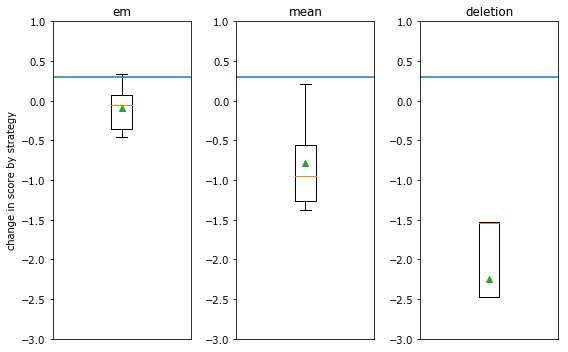

In [17]:
fig, grid = plt.subplots(1, 3)
grid[0].boxplot(em_scores, sym='', showmeans=True)
grid[1].boxplot(del_scores, sym='', showmeans=True)
grid[2].boxplot(si_scores, sym='', showmeans=True)
for ax, title in zip(grid, ['em', 'mean', 'deletion']):
    ax.set_ylim(-3., 1.)
    ax.axhline(reference_score, xmin=0, xmax=1)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_title(title)
grid[0].set_ylabel("change in score by strategy")
fig.tight_layout()
fig.savefig(os.path.join(img_dir, 'case_study_comparison.png'))